# Power demand forecasting with Amazon Sagemaker

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.metrics import mean_squared_error

In [ ]:
%pip install -U pip
%pip install -U setuptools wheel
%pip install autogluon  --no-cache-dir
%pip install ipywidgets==7.7.2

## Exploratory Data Analysis

### Load demand dataset

Data description:  
Power demand ('sein_demand') data is retrieved from SCADA systems and reported daily the next day of operation. Therefore, this data is close but has some differences to monthly reported data retrieved from meters ('demand').

- datetime: Date and time in "yyyy-mm-dd hh:mm:ss" format and 30-minute periods.  
- demand: Power demand of the national electric system (SEIN) in MW collected from meters.  
- sein_demand: Power demand of the national electric system (SEIN) in MW.  
- holiday: Boolean. True if date is a holiday.  
- workday: Boolean. True if date is a working day from Monday to Friday.  
- on_peak: Boolean. True if power demand occurs during peak hours from Monday to Saturday (no holidays), from 5:00 pm to 11:00 pm. 

In [4]:
df = pd.read_csv("./data/df_demand.csv", parse_dates=["datetime"])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353472 entries, 0 to 353471
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   datetime                  353472 non-null  datetime64[ns]
 1   demand                    353472 non-null  float64       
 2   coes_demand               125424 non-null  float64       
 3   import_exports            125424 non-null  float64       
 4   sein_demand               125424 non-null  float64       
 5   non_coes_demand           125424 non-null  float64       
 6   total_demand              350592 non-null  float64       
 7   total_demand_daily_plan   349728 non-null  float64       
 8   total_demand_weekly_plan  350592 non-null  float64       
 9   holiday                   353472 non-null  bool          
 10  workday                   353472 non-null  bool          
 11  on_peak                   353472 non-null  bool          
dtypes:

In [6]:
df

,datetime,demand,coes_demand,import_exports,sein_demand,non_coes_demand,total_demand,total_demand_daily_plan,total_demand_weekly_plan,holiday,workday,on_peak
0,2003-01-01 00:30:00,2358.98170,NaN,NaN,NaN,NaN,2306.76635,2304.71554,2292.96587,True,False,False
1,2003-01-01 01:00:00,2287.14719,NaN,NaN,NaN,NaN,2237.36810,2208.29031,2225.53541,True,False,False
2,2003-01-01 01:30:00,2209.47934,NaN,NaN,NaN,NaN,2150.86425,2125.24247,2147.93319,True,False,False
3,2003-01-01 02:00:00,2125.32866,NaN,NaN,NaN,NaN,2063.83669,2090.81638,2092.68125,True,False,False
4,2003-01-01 02:30:00,2000.68435,NaN,NaN,NaN,NaN,1990.51493,2035.67195,2015.89887,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
353467,2023-02-28 22:00:00,7213.33052,7152.17681,0.0,7152.17681,122.99258,7275.16939,7317.62767,7443.17706,False,True,True
353468,2023-02-28 22:30:00,7221.76318,7148.14381,0.0,7148.14381,98.71244,7246.85625,7287.74214,7335.39421,False,True,True
353469,2023-02-28 23:00:00,7116.23375,6915.98981,0.0,6915.98981,96.37898,7012.36879,7122.78297,7289.98850,False,True,True
353470,2023-02-28 23:30:00,6881.04613,6768.54381,0.0,6768.54381,96.41065,6864.95446,6903.65765,6844.23093,False,True,False


### Split datetime into time features

In [7]:
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['day_of_week'] = df['datetime'].dt.dayofweek
df['day_of_year'] = df['datetime'].dt.dayofyear
df['week_of_year'] = df['datetime'].dt.isocalendar().week
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353472 entries, 0 to 353471
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   datetime                  353472 non-null  datetime64[ns]
 1   demand                    353472 non-null  float64       
 2   coes_demand               125424 non-null  float64       
 3   import_exports            125424 non-null  float64       
 4   sein_demand               125424 non-null  float64       
 5   non_coes_demand           125424 non-null  float64       
 6   total_demand              350592 non-null  float64       
 7   total_demand_daily_plan   349728 non-null  float64       
 8   total_demand_weekly_plan  350592 non-null  float64       
 9   holiday                   353472 non-null  bool          
 10  workday                   353472 non-null  bool          
 11  on_peak                   353472 non-null  bool          
 12  ye

In [8]:
df.tail()

,datetime,demand,coes_demand,import_exports,sein_demand,non_coes_demand,total_demand,total_demand_daily_plan,total_demand_weekly_plan,holiday,workday,on_peak,year,month,day,hour,minute,day_of_week,day_of_year,week_of_year
353467,2023-02-28 22:00:00,7213.33052,7152.17681,0.0,7152.17681,122.99258,7275.16939,7317.62767,7443.17706,False,True,True,2023,2,28,22,0,1,59,9
353468,2023-02-28 22:30:00,7221.76318,7148.14381,0.0,7148.14381,98.71244,7246.85625,7287.74214,7335.39421,False,True,True,2023,2,28,22,30,1,59,9
353469,2023-02-28 23:00:00,7116.23375,6915.98981,0.0,6915.98981,96.37898,7012.36879,7122.78297,7289.98850,False,True,True,2023,2,28,23,0,1,59,9
353470,2023-02-28 23:30:00,6881.04613,6768.54381,0.0,6768.54381,96.41065,6864.95446,6903.65765,6844.23093,False,True,False,2023,2,28,23,30,1,59,9
353471,2023-03-01 00:00:00,6662.98518,6603.78881,0.0,6603.78881,96.39817,6700.18698,6733.97599,6835.07893,False,True,False,2023,3,1,0,0,2,60,9


In [9]:
df.describe()

,demand,coes_demand,import_exports,sein_demand,non_coes_demand,total_demand,total_demand_daily_plan,total_demand_weekly_plan,year,month,day,hour,minute,day_of_week,day_of_year,week_of_year
count,353472.000000,125424.000000,125424.000000,125424.000000,125424.000000,350592.000000,349728.000000,350592.000000,353472.000000,353472.000000,353472.000000,353472.000000,353472.000000,353472.000000,353472.000000,353472.0
mean,4419.780151,5884.979394,-3.275045,5888.254439,69.021983,4443.116927,4475.758392,4484.076835,2012.583843,6.482488,15.726100,11.500000,15.000000,3.000000,181.898592,26.435655
std,1411.267015,685.525517,17.616680,686.414786,23.878993,1439.980040,1439.482939,1447.002881,5.818880,3.464506,8.798426,6.922196,15.000021,2.000003,105.909842,15.131867
min,1559.304270,3206.138260,-1222.939720,3206.138260,2.467000,0.000000,1548.553300,1583.141410,2003.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.0
25%,3146.648865,5402.712158,0.000000,5405.482850,54.032753,3176.022582,3190.012895,3191.671482,2008.000000,3.000000,8.000000,5.750000,0.000000,1.000000,90.000000,13.0
50%,4375.692885,5930.473735,0.000000,5933.389585,68.184880,4404.791870,4436.422070,4428.758860,2013.000000,6.000000,16.000000,11.500000,15.000000,3.000000,182.000000,26.0
75%,5614.764810,6399.650940,0.000000,6405.029005,84.112705,5656.622970,5694.955013,5711.149660,2018.000000,9.000000,23.000000,17.250000,30.000000,5.000000,274.000000,40.0
max,7761.207040,7801.982000,438.153410,7801.982000,230.596000,7959.962000,7886.956680,7879.367230,2023.000000,12.000000,31.000000,23.000000,30.000000,6.000000,366.000000,53.0


### Visualizations

#### Power demand from January 2003 to February 2023

In [10]:
title = "Power demand from January 2003 to February 2023"

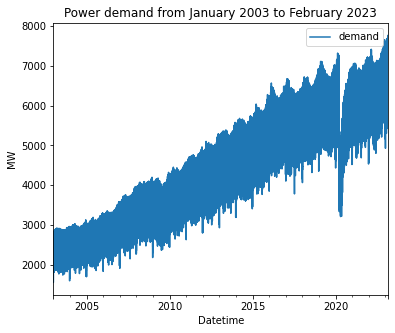

In [11]:
%matplotlib inline
df.plot(x='datetime', y=['demand'], figsize=(6, 5))
plt.title(title)
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.show()

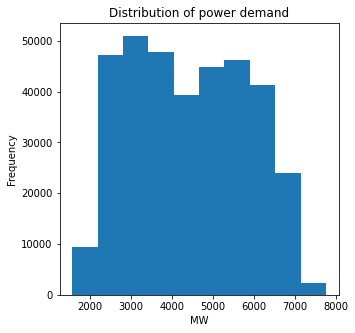

In [12]:
df['demand'].plot(kind='hist', figsize=(5, 5))
plt.title('Distribution of power demand')
plt.xlabel('MW')
plt.ylabel('Frequency')
plt.show()

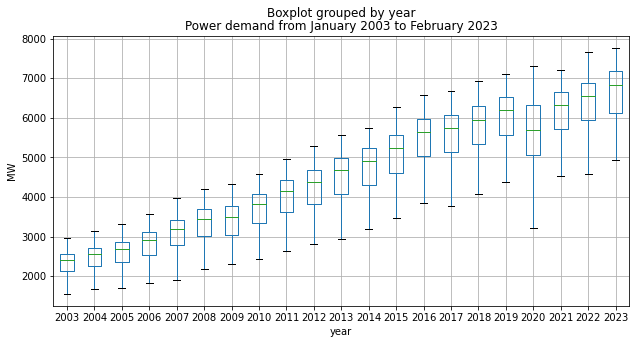

In [13]:
df.boxplot(column=['demand'], by='year', figsize=(10, 5))
plt.title(title)
plt.ylabel('MW')
plt.show()

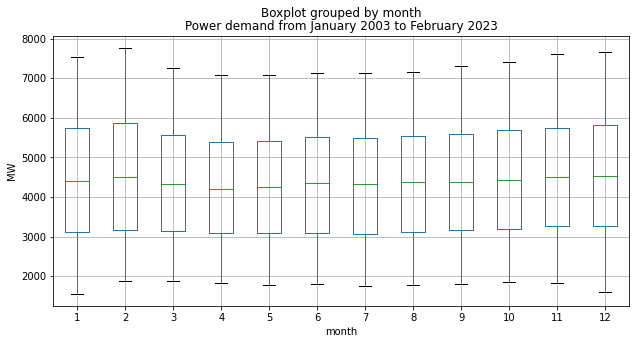

In [14]:
df.boxplot(column=['demand'], by='month', figsize=(10, 5))
plt.title(title)
plt.ylabel('MW')
plt.show()

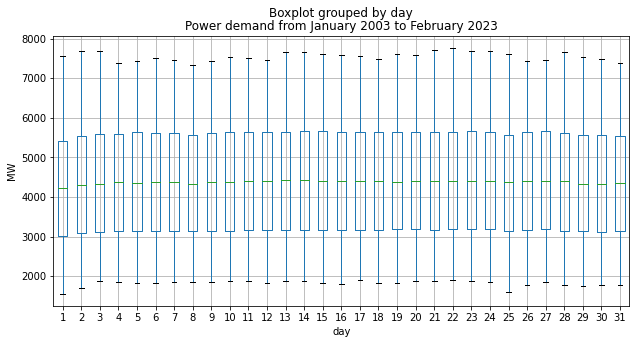

In [15]:
df.boxplot(column=['demand'], by='day', figsize=(10, 5))
plt.title(title)
plt.ylabel('MW')
plt.show()

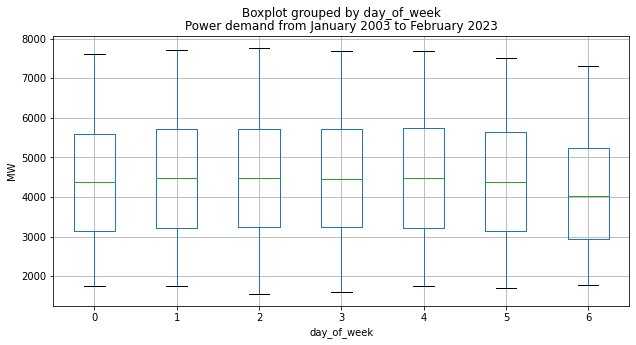

In [16]:
df.boxplot(column=['demand'], by='day_of_week', figsize=(10, 5))
plt.title(title)
plt.ylabel('MW')
plt.show()

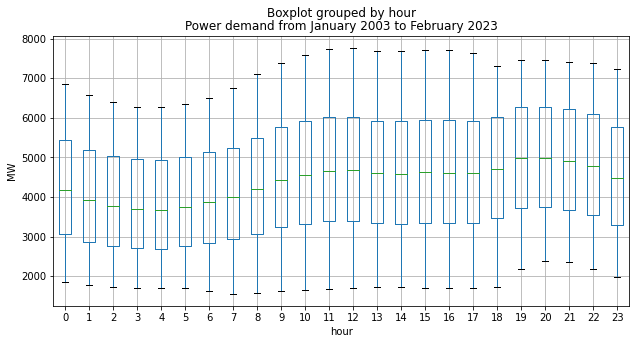

In [17]:
df.boxplot(column=['demand'], by='hour', figsize=(10, 5))
plt.title(title)
plt.ylabel('MW')
plt.show()

#### Power demand by year and month

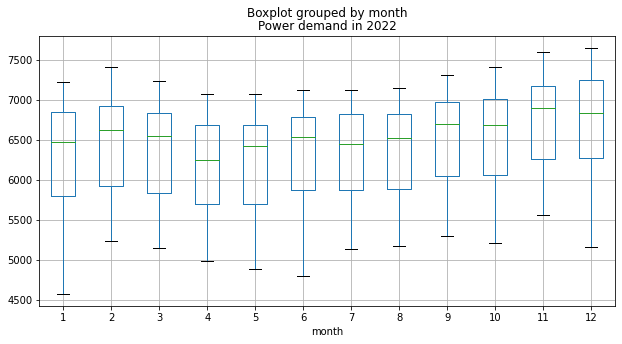

In [18]:
year_list = df['year'].unique()

# comment this line to explore the entire dataset
year_list = [2022]

for year in year_list:
    explore_df = df[(df['year'] == year)]
    explore_df.boxplot(column=['demand'], by='month', figsize=(10, 5))
    plt.title(f'Power demand in {year}')
    plt.show()

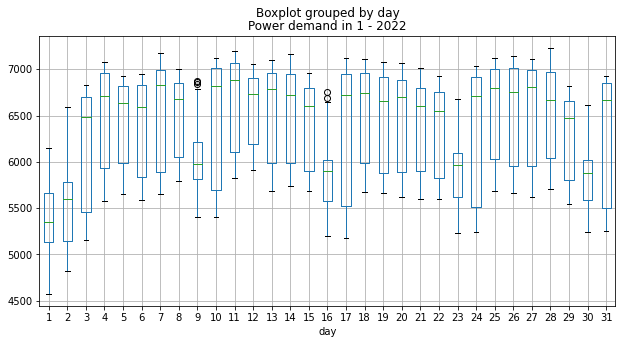

In [19]:
# demand by day
year_list = df['year'].unique()
month_list = df['month'].unique()

# comment this line to explore the entire dataset
year_list, month_list = [2022], [1]

for year in year_list:
    for month in month_list:
        explore_df = df[(df['year'] == year) &
                        (df['month'] == month)]
        explore_df.boxplot(column=['demand'], by='day', figsize=(10, 5))
        plt.title(f'Power demand in {month} - {year}')
        plt.show()

#### Power demand on peak hours

In [20]:
df_on_peak = df[df['on_peak']]
idx_peak = df_on_peak.groupby(
    [df_on_peak['year'], df_on_peak['month']])['demand'].idxmax()
df_peak_demand = df_on_peak.loc[idx_peak]
df_peak_demand.tail()

,datetime,demand,coes_demand,import_exports,sein_demand,non_coes_demand,total_demand,total_demand_daily_plan,total_demand_weekly_plan,holiday,workday,on_peak,year,month,day,hour,minute,day_of_week,day_of_year,week_of_year
347367,2022-10-24 20:00:00,7309.35844,7289.30000,0.0,7289.30000,67.85781,7357.15781,7191.20573,7191.77602,False,True,True,2022,10,24,20,0,0,297,43
348951,2022-11-26 20:00:00,7426.57477,7332.06600,0.0,7332.06600,61.15184,7393.21784,7262.21813,7224.53784,False,False,True,2022,11,26,20,0,5,330,47
349430,2022-12-06 19:30:00,7467.44974,7486.52074,0.0,7486.52074,81.35200,7567.87274,7529.65638,7511.43005,False,True,True,2022,12,6,19,30,1,340,49
351114,2023-01-10 21:30:00,7294.23545,7218.47000,0.0,7218.47000,88.93000,7307.40000,7124.96922,7391.50873,False,True,True,2023,1,10,21,30,1,10,2
352210,2023-02-02 17:30:00,7389.77578,7282.86000,0.0,7282.86000,99.19736,7382.01736,7163.48986,6985.94980,False,True,True,2023,2,2,17,30,3,33,5


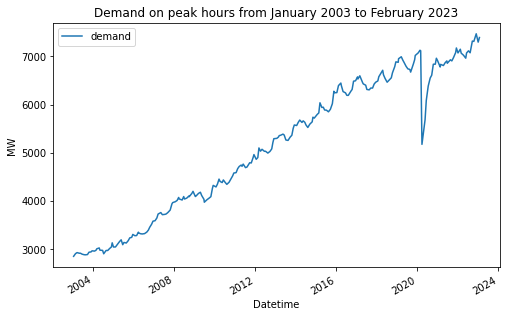

In [21]:
%matplotlib inline
df_peak_demand.plot(x='datetime', y=['demand'], figsize=(8, 5))
plt.title('Demand on peak hours from January 2003 to February 2023')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.show()

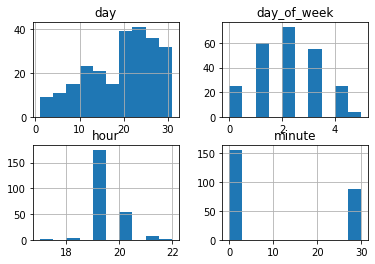

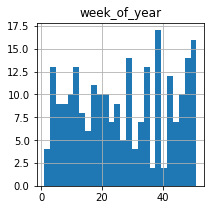

In [22]:
df_peak_demand[['day', 'day_of_week', 'hour', 'minute']].hist()
df_peak_demand[['week_of_year']].hist(bins=26, figsize=(3, 3))
plt.show()

### Save transformed dataframe as csv

In [23]:
df.to_csv('./data/df_transformed_demand.csv', index=False)

## Data preprocessing

### Load saved dataframe

In [24]:
df = pd.read_csv("./data/df_transformed_demand.csv", parse_dates=["datetime"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353472 entries, 0 to 353471
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   datetime                  353472 non-null  datetime64[ns]
 1   demand                    353472 non-null  float64       
 2   coes_demand               125424 non-null  float64       
 3   import_exports            125424 non-null  float64       
 4   sein_demand               125424 non-null  float64       
 5   non_coes_demand           125424 non-null  float64       
 6   total_demand              350592 non-null  float64       
 7   total_demand_daily_plan   349728 non-null  float64       
 8   total_demand_weekly_plan  350592 non-null  float64       
 9   holiday                   353472 non-null  bool          
 10  workday                   353472 non-null  bool          
 11  on_peak                   353472 non-null  bool          
 12  ye

### Replace power demand missing values ('sein_demand')

Power demand data ('sein_demand') has missing values on 2019-07-31, 2020-11-04, and 2020-12-25. This section explores how to replace missing values, either the mean between values from the previous and the next week or the mean between values from the previous and the next year.

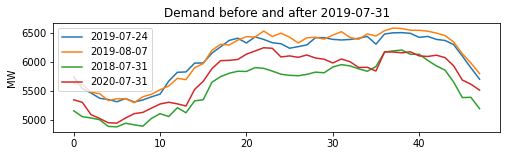

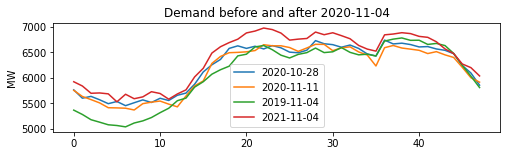

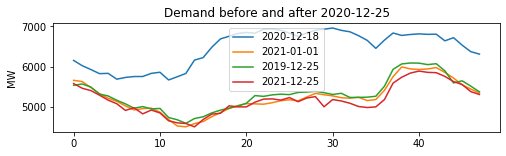

In [25]:
missing_sein_demand = df.loc[(df['datetime'].dt.year > 2016) &
                             (df['sein_demand'].isnull()),
                             ['datetime', 'sein_demand']].reset_index(drop=True)
num_rows = 48

prev_week_data = df.loc[
    df['datetime'].isin(missing_sein_demand['datetime'] - pd.DateOffset(days=7)),
    ['datetime', 'sein_demand']].reset_index(drop=True)
next_week_data = df.loc[
    df['datetime'].isin(missing_sein_demand['datetime'] + pd.DateOffset(days=7)),
    ['datetime', 'sein_demand']].reset_index(drop=True)
prev_year_data = df.loc[
    df['datetime'].isin(missing_sein_demand['datetime'] - pd.DateOffset(years=1)),
    ['datetime', 'sein_demand']].reset_index(drop=True)
next_year_data = df.loc[
    df['datetime'].isin(missing_sein_demand['datetime'] + pd.DateOffset(years=1)),
    ['datetime', 'sein_demand']].reset_index(drop=True)


for i in range(0, len(missing_sein_demand), num_rows):
    prev_week = prev_week_data.loc[i, 'datetime'].date()
    next_week = next_week_data.loc[i, 'datetime'].date()
    prev_year = prev_year_data.loc[i, 'datetime'].date()
    next_year = next_year_data.loc[i, 'datetime'].date()

    plt.figure(figsize=(8, 2))
    plt.plot(range(num_rows), prev_week_data.loc[i:i+num_rows-1, 'sein_demand'],
             label=f'{prev_week}')
    plt.plot(range(num_rows), next_week_data.loc[i:i+num_rows-1, 'sein_demand'],
             label=f'{next_week}')
    plt.plot(range(num_rows), prev_year_data.loc[i:i+num_rows-1, 'sein_demand'],
             label=f'{prev_year}')
    plt.plot(range(num_rows), next_year_data.loc[i:i+num_rows-1, 'sein_demand'],
             label=f'{next_year}')

    plt.title(f'Demand before and after {missing_sein_demand.loc[i, "datetime"].date()}')
    plt.ylabel('MW')
    plt.legend()
    plt.show()

Missing demand on 2019-07-31 and 2020-11-04 will be replaced with the mean between values from the previous and the next week. In the case of missing demand on 2020-12-25 will be replaced with the mean between values from the previous and the next year.

In [26]:
#  replace missing values
missing_sein_demand.loc[0:95, 'sein_demand'] = pd.concat(
    [prev_week_data['sein_demand'], next_week_data['sein_demand']],
    axis=1).mean(axis=1) 
missing_sein_demand.loc[96:144, 'sein_demand'] = pd.concat(
    [prev_year_data['sein_demand'], next_year_data['sein_demand']],
    axis=1).mean(axis=1) 

merged = pd.merge(df, missing_sein_demand, how='left', on='datetime', suffixes=('', '_y'))
merged['sein_demand'].fillna(merged['sein_demand_y'], inplace=True)
merged.drop('sein_demand_y', axis=1, inplace=True)
df = merged

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353472 entries, 0 to 353471
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   datetime                  353472 non-null  datetime64[ns]
 1   demand                    353472 non-null  float64       
 2   coes_demand               125424 non-null  float64       
 3   import_exports            125424 non-null  float64       
 4   sein_demand               125568 non-null  float64       
 5   non_coes_demand           125424 non-null  float64       
 6   total_demand              350592 non-null  float64       
 7   total_demand_daily_plan   349728 non-null  float64       
 8   total_demand_weekly_plan  350592 non-null  float64       
 9   holiday                   353472 non-null  bool          
 10  workday                   353472 non-null  bool          
 11  on_peak                   353472 non-null  bool          
 12  ye

### Resample data into 1-hour resolution

In [28]:
df_resampled = df.set_index('datetime').resample(
    '1h', label='right', closed='right')['sein_demand'].max().reset_index()

In [29]:
df = pd.merge(df_resampled, df, how='left', on='datetime', suffixes=('', '_y'))
df = df.drop(['sein_demand_y'], axis=1)

In [30]:
df.tail()

,datetime,sein_demand,demand,coes_demand,import_exports,non_coes_demand,total_demand,total_demand_daily_plan,total_demand_weekly_plan,holiday,workday,on_peak,year,month,day,hour,minute,day_of_week,day_of_year,week_of_year
176731,2023-02-28 20:00:00,7333.38281,7318.01873,7319.58081,0.0,122.78207,7442.36288,7416.76230,7474.18293,False,True,True,2023,2,28,20,0,1,59,9
176732,2023-02-28 21:00:00,7263.08881,7282.63385,7220.55081,0.0,124.68240,7345.23321,7385.63670,7434.09560,False,True,True,2023,2,28,21,0,1,59,9
176733,2023-02-28 22:00:00,7189.28181,7213.33052,7152.17681,0.0,122.99258,7275.16939,7317.62767,7443.17706,False,True,True,2023,2,28,22,0,1,59,9
176734,2023-02-28 23:00:00,7148.14381,7116.23375,6915.98981,0.0,96.37898,7012.36879,7122.78297,7289.98850,False,True,True,2023,2,28,23,0,1,59,9
176735,2023-03-01 00:00:00,6768.54381,6662.98518,6603.78881,0.0,96.39817,6700.18698,6733.97599,6835.07893,False,True,False,2023,3,1,0,0,2,60,9


### Split data into train and test sets

In [31]:
train_start_date = pd.to_datetime('2020-01-01').date()
train_end_date = pd.to_datetime('2022-05-31').date()
test_start_date = pd.to_datetime('2022-06-01').date()
test_end_date = pd.to_datetime('2022-12-31').date()

df_train = df[(df['datetime'].dt.date >= train_start_date) &
              (df['datetime'].dt.date <= train_end_date)]
df_test = df[(df['datetime'].dt.date >= test_start_date) &
             (df['datetime'].dt.date <= test_end_date)]

## Benchmark model

A simple naïve model will be used as a benchmark model where the most recent known value is used as the predicted value. In this manner, the previous day power demand at a specific time is used as the predicted value for the next day demand at the same time. In order to compare the performance of the benchmark model and the machine learning model, the RMSE will be calculated on the same test dataset.

### Data preparation

In [32]:
df['sein_demand_lag_24h'] = df['sein_demand'].shift(24)

In [33]:
train_start_date = pd.to_datetime('2020-01-01').date()
train_end_date = pd.to_datetime('2022-05-31').date()
test_start_date = pd.to_datetime('2022-06-01').date()
test_end_date = pd.to_datetime('2022-12-31').date()

df_train = df[(df['datetime'].dt.date >= train_start_date) &
              (df['datetime'].dt.date <= train_end_date)]
df_test = df[(df['datetime'].dt.date >= test_start_date) &
             (df['datetime'].dt.date <= test_end_date)]

In [34]:
df_test.head()

,datetime,sein_demand,demand,coes_demand,import_exports,non_coes_demand,total_demand,total_demand_daily_plan,total_demand_weekly_plan,holiday,...,on_peak,year,month,day,hour,minute,day_of_week,day_of_year,week_of_year,sein_demand_lag_24h
170183,2022-06-01 00:00:00,6168.697,6143.19363,5968.600,-39.236,91.99043,6060.59043,6092.50847,6227.73199,False,...,False,2022,6,1,0,0,2,152,22,6208.68078
170184,2022-06-01 01:00:00,5972.091,5896.26429,5821.494,-36.596,107.23000,5928.72400,5909.51947,5890.56786,False,...,False,2022,6,1,1,0,2,152,22,5893.00000
170185,2022-06-01 02:00:00,5784.791,5719.86008,5651.501,-36.533,107.43000,5758.93100,5755.95976,5765.22110,False,...,False,2022,6,1,2,0,2,152,22,5788.80000
170186,2022-06-01 03:00:00,5700.749,5654.47784,5663.861,-36.888,106.91000,5770.77100,5715.44337,5677.75131,False,...,False,2022,6,1,3,0,2,152,22,5685.80000
170187,2022-06-01 04:00:00,5685.999,5690.33693,5584.763,-38.551,107.00000,5691.76300,5716.52640,5641.63561,False,...,False,2022,6,1,4,0,2,152,22,5642.80000


### Predictions

In [35]:
predictions = df_test.loc[:,['datetime', 'sein_demand_lag_24h']]
predictions.columns = ['datetime', 'predictions']

In [36]:
predictions.head()

,datetime,predictions
170183,2022-06-01 00:00:00,6208.68078
170184,2022-06-01 01:00:00,5893.00000
170185,2022-06-01 02:00:00,5788.80000
170186,2022-06-01 03:00:00,5685.80000
170187,2022-06-01 04:00:00,5642.80000


### Evaluate benchmark model

In [37]:
rmse = round(
    mean_squared_error(
        df_test['sein_demand'], predictions['predictions'], squared=False
    ), 4
)
print(f"RMSE: {rmse}")

RMSE: 337.7162


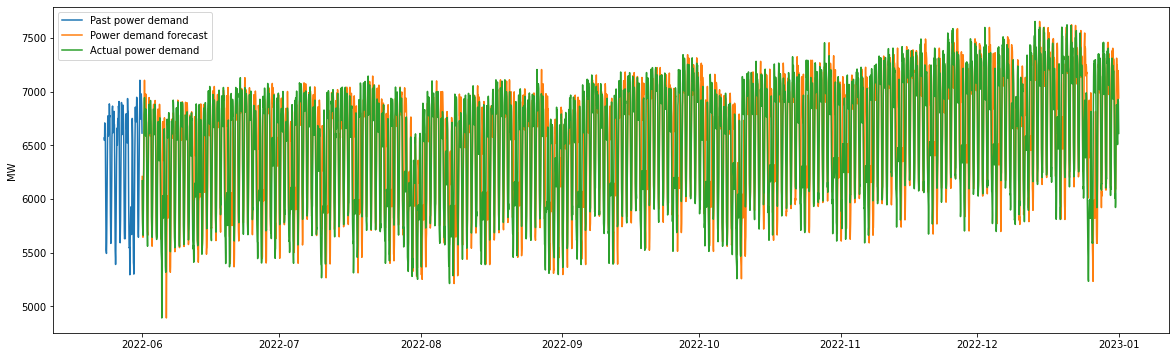

In [38]:
plt.figure(figsize=(20, 6))

x_past = df_train['datetime']
x_pred = predictions['datetime']
x_test = df_test['datetime']

y_past = df_train["sein_demand"]
y_pred = predictions['predictions']
y_test = df_test["sein_demand"]

plt.plot(x_past[-200:], y_past[-200:], label="Past power demand")
plt.plot(x_pred, y_pred, label="Power demand forecast")
plt.plot(x_test, y_test, label="Actual power demand")

plt.ylabel('MW')
plt.legend();

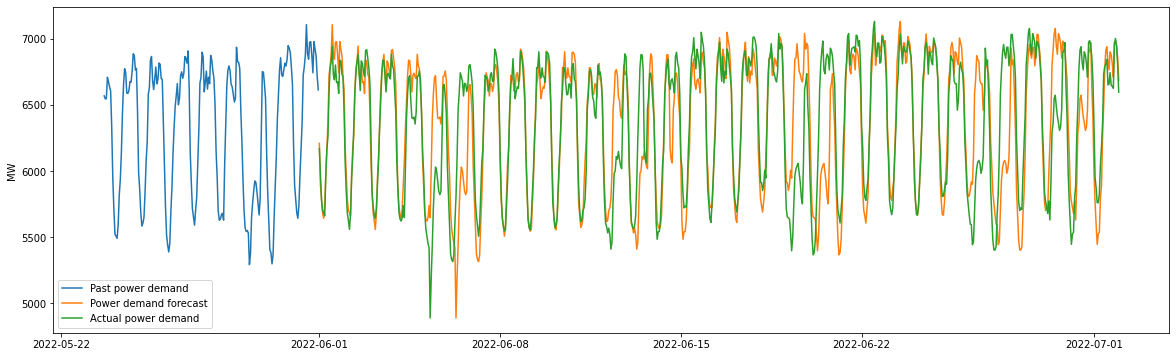

In [39]:
# demand forecast sample for June 2022
plt.figure(figsize=(20, 6))

x_past = df_train['datetime']
x_pred = predictions['datetime']
x_test = df_test['datetime']

y_past = df_train["sein_demand"]
y_pred = predictions['predictions'][0:24*31]
y_test = df_test["sein_demand"][0:24*31]

plt.plot(x_past[-200:], y_past[-200:], label="Past power demand")
plt.plot(x_pred[0:24*31], y_pred, label="Power demand forecast")
plt.plot(x_test[0:24*31], y_test, label="Actual power demand")

plt.ylabel('MW')
plt.legend();

## Model training using AutoGluon’s TimeSeriesPredictor

### Data preparation

In [40]:
prediction_length = 24

In [41]:
df_columns = ['datetime', 'sein_demand']
train_data = df_train.loc[:, df_columns]
test_data = df_test.loc[:, df_columns]

item_id = "D1"
train_data['item_id'] = item_id
test_data['item_id'] = item_id

In [43]:
train_data = TimeSeriesDataFrame.from_data_frame(
    train_data,
    id_column="item_id",
    timestamp_column="datetime"
)
test_data = TimeSeriesDataFrame.from_data_frame(
    test_data,
    id_column="item_id",
    timestamp_column="datetime"
)

In [44]:
train_data.head()

sein_demand
item_id timestamp                       
D1      2020-01-01 00:00:00   5978.89960
        2020-01-01 01:00:00   5520.27961
        2020-01-01 02:00:00   5391.76270
        2020-01-01 03:00:00   5207.10367
        2020-01-01 04:00:00   5022.78269

In [45]:
test_data.head()

sein_demand
item_id timestamp                       
D1      2022-06-01 00:00:00     6168.697
        2022-06-01 01:00:00     5972.091
        2022-06-01 02:00:00     5784.791
        2022-06-01 03:00:00     5700.749
        2022-06-01 04:00:00     5685.999

### Fitting model

In [47]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    path="./AutogluonModels/ag-raw-1h-sein-demand",
    target="sein_demand",
    eval_metric="RMSE",
)

In [49]:
predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=1200,
)

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: medium_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'RMSE',
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'medium_quality',
 'prediction_length': 24,
 'random_seed': None,
 'target': 'sein_demand',
 'time_limit': 1200}
Provided training data set with 21168 rows, 1 items (item = single time series). Average time series length is 21168.0.
Training artifacts will be saved to: /root/power-demand-forecasting/AutogluonModels/ag-raw-1h-sein-demand
AutoGluon will save models to ./AutogluonModels/ag-raw-1h-sein-demand/
AutoGluon will gauge predictive performance using evaluation metric: 'RMSE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided dataset contains following columns:
	target:           'sein_demand'
tuning_data is None. Will use th

### Load saved predictor

Loading predictor from path ./AutogluonModels/ag-raw-1h-sein-demand/


              model   score_val  pred_time_val  fit_time_marginal  fit_order
0  WeightedEnsemble  -89.923456       5.324104           3.923670          9
1            DeepAR  -95.080566       0.164673         385.393134          8
2               ETS -123.125405       5.159431           0.000760          3
3  AutoGluonTabular -135.504051       0.161320          14.217565          7
4             Theta -148.707204       6.655112           0.000704          4
5           AutoETS -149.052232      91.125074           0.001108          6
6     SeasonalNaive -234.137833       0.065664           0.000687          2
7             ARIMA -488.283475       1.820117           0.000712          5
8             Naive -498.012318       0.070478           0.004443          1


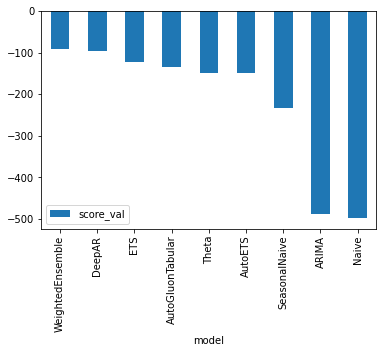

In [50]:
predictor = TimeSeriesPredictor.load('./AutogluonModels/ag-raw-1h-sein-demand')
predictor.leaderboard().plot(kind="bar", x="model", y="score_val")
plt.show()

### Predictions

In [51]:
# leave num_days = 0 to generate forecasts on the entire test data
num_days = 0

In [52]:
num_instances = 0
if num_days != 0:
    num_instances = num_days * prediction_length
else:
    num_instances = len(test_data)

In [53]:
future_known_covariates = test_data[0:num_instances]

In [54]:
data = train_data
predictions = predictor.predict(data, known_covariates=future_known_covariates)
for i in range(0, num_instances - prediction_length, prediction_length):
    data = pd.concat([data, test_data[i: i + prediction_length]])
    new_predictions = predictor.predict(data, known_covariates=future_known_covariates)
    predictions = pd.concat([predictions, new_predictions])

Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Global seed set to 123
Model not specified in predict, will default to the model with the 

In [55]:
print(f"Number of predictions: {len(predictions)}")

Number of predictions: 5136


In [56]:
predictions.head()

mean          0.1          0.2  \
item_id timestamp                                                    
D1      2022-06-01 00:00:00  6184.237879  6087.441600  6117.046731   
        2022-06-01 01:00:00  5908.550471  5798.427243  5839.185271   
        2022-06-01 02:00:00  5741.779475  5623.629345  5666.382693   
        2022-06-01 03:00:00  5642.086399  5525.622375  5572.898894   
        2022-06-01 04:00:00  5635.336589  5518.307284  5558.445247   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
D1      2022-06-01 00:00:00  6138.849071  6159.232121  6181.186121   
        2022-06-01 01:00:00  5862.294011  5886.275107  5906.630550   
        2022-06-01 02:00:00  5692.697286  5718.943182  5743.734554   
        2022-06-01 03:00:00  5602.714783  5627.418241  5644.433567   
        2022-06-01 04:00:00  5591.407978  5619.939295  5636.572429   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
D1      2022-06-01 00:00:00  6201.049790  6222.403054  6250.696117   
        2022-06-01 01:00:00  5923.705230  5947.521776  5972.874656   
        2022-06-01 02:00:00  5764.189988  5781.416352  5815.957020   
        2022-06-01 03:00:00  5666.948892  5690.704108  5716.518533   
        2022-06-01 04:00:00  5654.830074  5678.022036  5707.900782   

                                     0.9  
item_id timestamp                         
D1      2022-06-01 00:00:00  6284.063455  
        2022-06-01 01:00:00  6017.521357  
        2022-06-01 02:00:00  5858.809977  
        2022-06-01 03:00:00  5755.100716  
        2022-06-01 04:00:00  5744.201831

### Evaluate predictions

In [57]:
rmse = mean_squared_error(
    test_data[0:num_instances]['sein_demand'], predictions['mean'],
    squared=False
)
print(f"RMSE: {rmse}")

RMSE: 137.20409194217643


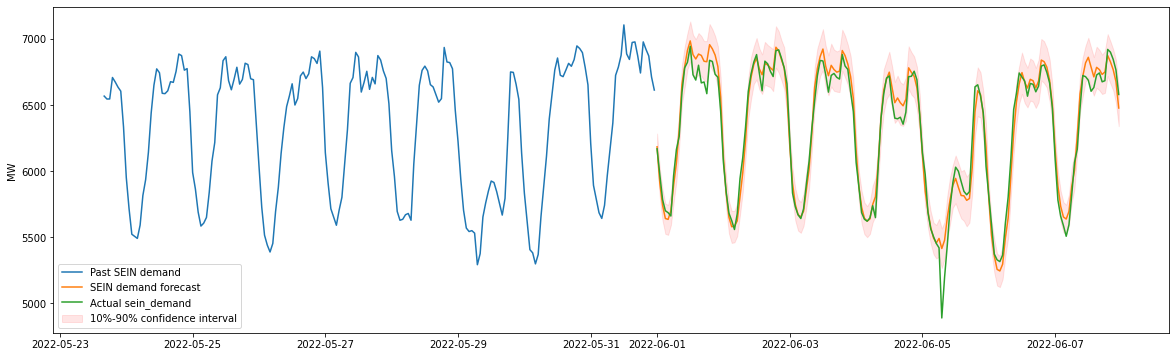

In [58]:
# demand forecast for first week of June 2022
plt.figure(figsize=(20, 6))

item_id = item_id
y_past = train_data.loc[item_id]["sein_demand"]
y_pred = predictions.loc[item_id][0:24*7]
y_test = test_data.loc[item_id]["sein_demand"][0:24*7]

plt.plot(y_past[-200:], label="Past SEIN demand")
plt.plot(y_pred["mean"], label="SEIN demand forecast")
plt.plot(y_test, label="Actual sein_demand")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red",
    alpha=0.1, label="10%-90% confidence interval"
)
plt.ylabel('MW')
plt.legend();

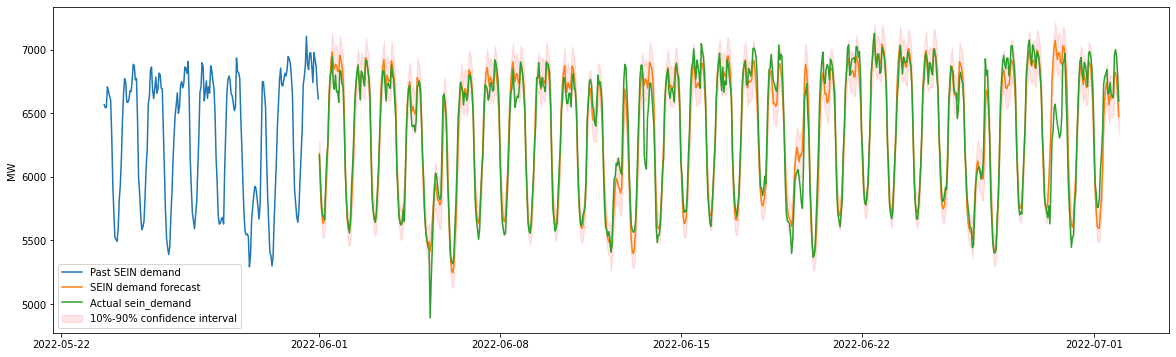

In [59]:
# demand forecast for June 2022
plt.figure(figsize=(20, 6))

item_id = item_id
y_past = train_data.loc[item_id]["sein_demand"]
y_pred = predictions.loc[item_id][0:24*31]
y_test = test_data.loc[item_id]["sein_demand"][0:24*31]

plt.plot(y_past[-200:], label="Past SEIN demand")
plt.plot(y_pred["mean"], label="SEIN demand forecast")
plt.plot(y_test, label="Actual sein_demand")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red",
    alpha=0.1, label="10%-90% confidence interval"
)
plt.ylabel('MW')
plt.legend();

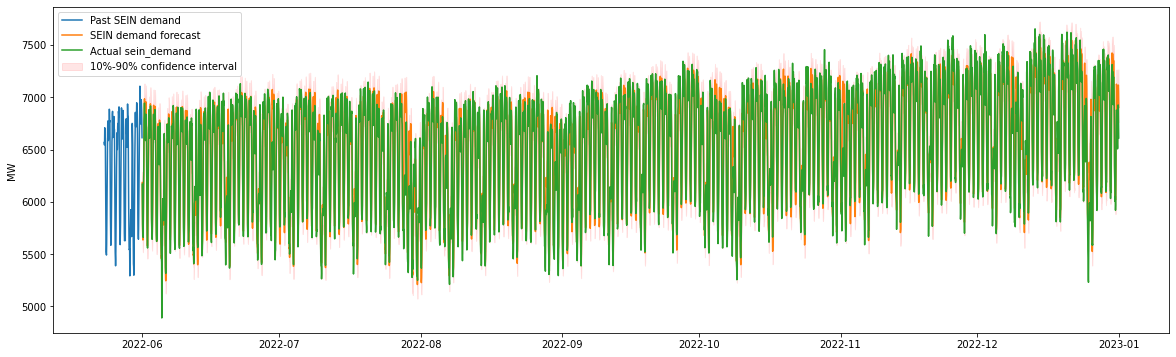

In [60]:
plt.figure(figsize=(20, 6))

item_id = item_id
y_past = train_data.loc[item_id]["sein_demand"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["sein_demand"][0:num_instances]

plt.plot(y_past[-200:], label="Past SEIN demand")
plt.plot(y_pred["mean"], label="SEIN demand forecast")
plt.plot(y_test, label="Actual sein_demand")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red",
    alpha=0.1, label="10%-90% confidence interval"
)
plt.ylabel('MW')
plt.legend();

#### Evaluate predictions on peak hours

In [61]:
df_predictions = predictions.reset_index()
df_predictions = df_predictions.rename(columns={
    'timestamp': 'datetime',
    'mean': 'predictions'})
df_predictions = df_predictions[['datetime', 'predictions']]
df_predictions = pd.merge(df_test, df_predictions, how='left', on='datetime')

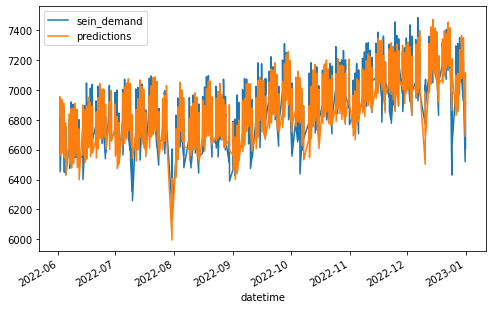

In [62]:
(df_predictions[df_predictions['on_peak']]
 .plot(x='datetime', y=['sein_demand', 'predictions'], figsize=(8, 5)))
plt.show()

In [63]:
idx = df_predictions[df_predictions['on_peak']].groupby(
    df_predictions['datetime'].dt.month)['predictions'].idxmax()
df_predictions.loc[idx, ['datetime', 'predictions']]

,datetime,predictions
523,2022-06-22 19:00:00,7044.000784
1219,2022-07-21 19:00:00,7089.331665
1916,2022-08-19 20:00:00,7060.046229
2899,2022-09-29 19:00:00,7257.951246
3523,2022-10-25 19:00:00,7214.037290
4028,2022-11-15 20:00:00,7345.938341
4724,2022-12-14 20:00:00,7474.227552


In [64]:
idx = df_predictions[df_predictions['on_peak']].groupby(
    df_predictions['datetime'].dt.month)['sein_demand'].idxmax()
df_predictions.loc[idx, ['datetime', 'sein_demand']]

,datetime,sein_demand
355,2022-06-15 19:00:00,7047.66300
1172,2022-07-19 20:00:00,7094.47800
1892,2022-08-18 20:00:00,7097.03160
2851,2022-09-27 19:00:00,7311.18590
3500,2022-10-24 20:00:00,7291.40000
4244,2022-11-24 20:00:00,7457.30800
4532,2022-12-06 20:00:00,7486.52074


## Feature Engineering

### Identify COVID period

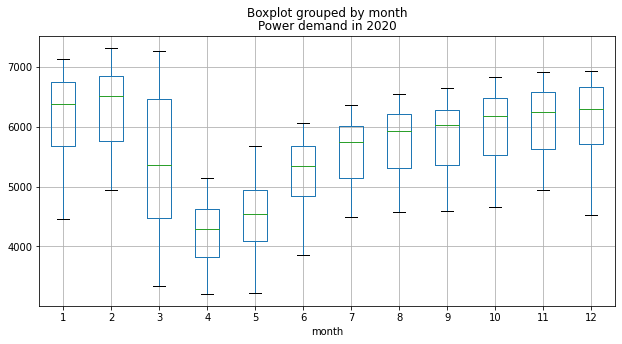

In [66]:
covid_year = 2020
explore_df = df[(df['year'] == covid_year)]
explore_df.boxplot(column=['demand'], by='month', figsize=(10, 5))
plt.title(f'Power demand in {covid_year}')
plt.show()

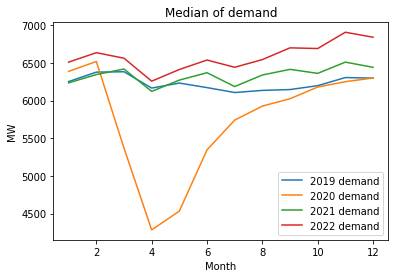

In [67]:
demand_2019 = df[df['datetime'].dt.year == 2019].groupby(
    [df['datetime'].dt.month])['demand'].median()
demand_2020 = df[df['datetime'].dt.year == 2020].groupby(
    [df['datetime'].dt.month])['demand'].median()
demand_2021 = df[df['datetime'].dt.year == 2021].groupby(
    [df['datetime'].dt.month])['demand'].median()
demand_2022 = df[df['datetime'].dt.year == 2022].groupby(
    [df['datetime'].dt.month])['demand'].median()

%matplotlib inline
plt.plot(demand_2019, label='2019 demand')
plt.plot(demand_2020, label='2020 demand')
plt.plot(demand_2021, label='2021 demand')
plt.plot(demand_2022, label='2022 demand')
plt.title('Median of demand')
plt.xlabel('Month')
plt.ylabel('MW')
plt.legend()
plt.show()

In [68]:
covid_start_date = pd.to_datetime('2020-03-15').date()
covid_end_date = pd.to_datetime('2020-09-30').date()

df['on_covid'] = ((df['datetime'].dt.date >= covid_start_date) &
                  (df['datetime'].dt.date <= covid_end_date))

### Add features

In [69]:
df['season'] = pd.cut(df['datetime'].dt.month, [0, 3, 6, 9, 12],
                      labels=['summer', 'fall', 'winter', 'spring'])
df['time_of_day'] = pd.cut(df['datetime'].dt.hour, [-1, 5, 11, 17, 23],
                           labels=['night', 'morning', 'noon', 'evening'])
dummies = pd.get_dummies(df[['season', 'time_of_day']])
df = pd.concat([df, dummies], axis='columns')
df

,datetime,sein_demand,demand,coes_demand,import_exports,non_coes_demand,total_demand,total_demand_daily_plan,total_demand_weekly_plan,holiday,...,season,time_of_day,season_summer,season_fall,season_winter,season_spring,time_of_day_night,time_of_day_morning,time_of_day_noon,time_of_day_evening
0,2003-01-01 01:00:00,NaN,2287.14719,NaN,NaN,NaN,2237.36810,2208.29031,2225.53541,True,...,summer,night,1,0,0,0,1,0,0,0
1,2003-01-01 02:00:00,NaN,2125.32866,NaN,NaN,NaN,2063.83669,2090.81638,2092.68125,True,...,summer,night,1,0,0,0,1,0,0,0
2,2003-01-01 03:00:00,NaN,1977.72058,NaN,NaN,NaN,1938.74353,1958.90395,1954.42485,True,...,summer,night,1,0,0,0,1,0,0,0
3,2003-01-01 04:00:00,NaN,1856.49062,NaN,NaN,NaN,1840.14126,1832.89618,1871.88025,True,...,summer,night,1,0,0,0,1,0,0,0
4,2003-01-01 05:00:00,NaN,1813.86509,NaN,NaN,NaN,1792.87716,1764.68205,1783.29585,True,...,summer,night,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176731,2023-02-28 20:00:00,7333.38281,7318.01873,7319.58081,0.0,122.78207,7442.36288,7416.76230,7474.18293,False,...,summer,evening,1,0,0,0,0,0,0,1
176732,2023-02-28 21:00:00,7263.08881,7282.63385,7220.55081,0.0,124.68240,7345.23321,7385.63670,7434.09560,False,...,summer,evening,1,0,0,0,0,0,0,1
176733,2023-02-28 22:00:00,7189.28181,7213.33052,7152.17681,0.0,122.99258,7275.16939,7317.62767,7443.17706,False,...,summer,evening,1,0,0,0,0,0,0,1
176734,2023-02-28 23:00:00,7148.14381,7116.23375,6915.98981,0.0,96.37898,7012.36879,7122.78297,7289.98850,False,...,summer,evening,1,0,0,0,0,0,0,1


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176736 entries, 0 to 176735
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   datetime                  176736 non-null  datetime64[ns]
 1   sein_demand               62784 non-null   float64       
 2   demand                    176736 non-null  float64       
 3   coes_demand               62712 non-null   float64       
 4   import_exports            62712 non-null   float64       
 5   non_coes_demand           62712 non-null   float64       
 6   total_demand              175296 non-null  float64       
 7   total_demand_daily_plan   174864 non-null  float64       
 8   total_demand_weekly_plan  175296 non-null  float64       
 9   holiday                   176736 non-null  bool          
 10  workday                   176736 non-null  bool          
 11  on_peak                   176736 non-null  bool          
 12  ye

### Split data into train and test sets

In [71]:
train_start_date = pd.to_datetime('2020-01-01').date()
train_end_date = pd.to_datetime('2022-05-31').date()
test_start_date = pd.to_datetime('2022-06-01').date()
test_end_date = pd.to_datetime('2022-12-31').date()

df_train = df[(df['datetime'].dt.date >= train_start_date) &
              (df['datetime'].dt.date <= train_end_date)]
df_test = df[(df['datetime'].dt.date >= test_start_date) &
             (df['datetime'].dt.date <= test_end_date)]

In [72]:
df_test

,datetime,sein_demand,demand,coes_demand,import_exports,non_coes_demand,total_demand,total_demand_daily_plan,total_demand_weekly_plan,holiday,...,season,time_of_day,season_summer,season_fall,season_winter,season_spring,time_of_day_night,time_of_day_morning,time_of_day_noon,time_of_day_evening
170183,2022-06-01 00:00:00,6168.69700,6143.19363,5968.60000,-39.236,91.99043,6060.59043,6092.50847,6227.73199,False,...,fall,night,0,1,0,0,1,0,0,0
170184,2022-06-01 01:00:00,5972.09100,5896.26429,5821.49400,-36.596,107.23000,5928.72400,5909.51947,5890.56786,False,...,fall,night,0,1,0,0,1,0,0,0
170185,2022-06-01 02:00:00,5784.79100,5719.86008,5651.50100,-36.533,107.43000,5758.93100,5755.95976,5765.22110,False,...,fall,night,0,1,0,0,1,0,0,0
170186,2022-06-01 03:00:00,5700.74900,5654.47784,5663.86100,-36.888,106.91000,5770.77100,5715.44337,5677.75131,False,...,fall,night,0,1,0,0,1,0,0,0
170187,2022-06-01 04:00:00,5685.99900,5690.33693,5584.76300,-38.551,107.00000,5691.76300,5716.52640,5641.63561,False,...,fall,night,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175314,2022-12-31 19:00:00,6787.83983,6788.26591,6787.83983,0.000,100.94259,6888.78242,6960.40059,6865.67258,False,...,spring,evening,0,0,0,1,0,0,0,1
175315,2022-12-31 20:00:00,6926.38705,6928.58329,6926.38705,0.000,102.26507,7028.65212,7103.52937,7044.19185,False,...,spring,evening,0,0,0,1,0,0,0,1
175316,2022-12-31 21:00:00,6905.67512,6884.59433,6846.05794,0.000,102.15967,6948.21761,7032.31499,7004.06229,False,...,spring,evening,0,0,0,1,0,0,0,1
175317,2022-12-31 22:00:00,6744.99536,6717.04400,6597.22934,0.000,94.49385,6691.72319,6875.80089,6915.06825,False,...,spring,evening,0,0,0,1,0,0,0,1


## Model training with new features

### Data preparation

In [73]:
prediction_length = 24

In [76]:
df.columns

Index(['datetime', 'sein_demand', 'demand', 'coes_demand', 'import_exports',
       'non_coes_demand', 'total_demand', 'total_demand_daily_plan',
       'total_demand_weekly_plan', 'holiday', 'workday', 'on_peak', 'year',
       'month', 'day', 'hour', 'minute', 'day_of_week', 'day_of_year',
       'week_of_year', 'sein_demand_lag_24h', 'on_covid', 'season',
       'time_of_day', 'season_summer', 'season_fall', 'season_winter',
       'season_spring', 'time_of_day_night', 'time_of_day_morning',
       'time_of_day_noon', 'time_of_day_evening'],
      dtype='object')

In [77]:
df_columns = ['datetime', 'sein_demand', 'workday', 'on_peak',
              'holiday', 'on_covid', 'season_summer', 'season_fall',
              'season_winter', 'season_spring', 'time_of_day_night',
              'time_of_day_morning', 'time_of_day_noon', 'time_of_day_evening']
train_data = df_train.loc[:, df_columns]
test_data = df_test.loc[:, df_columns]

item_id = "D1"
train_data['item_id'] = item_id
test_data['item_id'] = item_id

In [78]:
train_data = TimeSeriesDataFrame.from_data_frame(
    train_data,
    id_column="item_id",
    timestamp_column="datetime"
)
test_data = TimeSeriesDataFrame.from_data_frame(
    test_data,
    id_column="item_id",
    timestamp_column="datetime"
)

In [79]:
train_data.head()

sein_demand  workday  on_peak  holiday  on_covid  \
item_id timestamp                                                               
D1      2020-01-01 00:00:00   5978.89960    False    False     True     False   
        2020-01-01 01:00:00   5520.27961    False    False     True     False   
        2020-01-01 02:00:00   5391.76270    False    False     True     False   
        2020-01-01 03:00:00   5207.10367    False    False     True     False   
        2020-01-01 04:00:00   5022.78269    False    False     True     False   

                             season_summer  season_fall  season_winter  \
item_id timestamp                                                        
D1      2020-01-01 00:00:00              1            0              0   
        2020-01-01 01:00:00              1            0              0   
        2020-01-01 02:00:00              1            0              0   
        2020-01-01 03:00:00              1            0              0   
        2020-01-01 04:00:00              1            0              0   

                             season_spring  time_of_day_night  \
item_id timestamp                                               
D1      2020-01-01 00:00:00              0                  1   
        2020-01-01 01:00:00              0                  1   
        2020-01-01 02:00:00              0                  1   
        2020-01-01 03:00:00              0                  1   
        2020-01-01 04:00:00              0                  1   

                             time_of_day_morning  time_of_day_noon  \
item_id timestamp                                                    
D1      2020-01-01 00:00:00                    0                 0   
        2020-01-01 01:00:00                    0                 0   
        2020-01-01 02:00:00                    0                 0   
        2020-01-01 03:00:00                    0                 0   
        2020-01-01 04:00:00                    0                 0   

                             time_of_day_evening  
item_id timestamp                                 
D1      2020-01-01 00:00:00                    0  
        2020-01-01 01:00:00                    0  
        2020-01-01 02:00:00                    0  
        2020-01-01 03:00:00                    0  
        2020-01-01 04:00:00                    0

In [80]:
test_data.head()

sein_demand  workday  on_peak  holiday  on_covid  \
item_id timestamp                                                               
D1      2022-06-01 00:00:00     6168.697     True    False    False     False   
        2022-06-01 01:00:00     5972.091     True    False    False     False   
        2022-06-01 02:00:00     5784.791     True    False    False     False   
        2022-06-01 03:00:00     5700.749     True    False    False     False   
        2022-06-01 04:00:00     5685.999     True    False    False     False   

                             season_summer  season_fall  season_winter  \
item_id timestamp                                                        
D1      2022-06-01 00:00:00              0            1              0   
        2022-06-01 01:00:00              0            1              0   
        2022-06-01 02:00:00              0            1              0   
        2022-06-01 03:00:00              0            1              0   
        2022-06-01 04:00:00              0            1              0   

                             season_spring  time_of_day_night  \
item_id timestamp                                               
D1      2022-06-01 00:00:00              0                  1   
        2022-06-01 01:00:00              0                  1   
        2022-06-01 02:00:00              0                  1   
        2022-06-01 03:00:00              0                  1   
        2022-06-01 04:00:00              0                  1   

                             time_of_day_morning  time_of_day_noon  \
item_id timestamp                                                    
D1      2022-06-01 00:00:00                    0                 0   
        2022-06-01 01:00:00                    0                 0   
        2022-06-01 02:00:00                    0                 0   
        2022-06-01 03:00:00                    0                 0   
        2022-06-01 04:00:00                    0                 0   

                             time_of_day_evening  
item_id timestamp                                 
D1      2022-06-01 00:00:00                    0  
        2022-06-01 01:00:00                    0  
        2022-06-01 02:00:00                    0  
        2022-06-01 03:00:00                    0  
        2022-06-01 04:00:00                    0

### Fitting model

In [81]:
known_covariates_names = ['workday', 'on_peak',
                          'holiday', 'on_covid', 'season_summer', 'season_fall',
                          'season_winter', 'season_spring', 'time_of_day_night',
                          'time_of_day_morning', 'time_of_day_noon', 'time_of_day_evening']

In [82]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    path="./AutogluonModels/ag-new-features-1h-sein-demand",
    target="sein_demand",
    eval_metric="RMSE",
    known_covariates_names=known_covariates_names,
)

In [83]:
predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=1200,
)

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: medium_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'RMSE',
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'medium_quality',
 'prediction_length': 24,
 'random_seed': None,
 'target': 'sein_demand',
 'time_limit': 1200}
Provided training data set with 21168 rows, 1 items (item = single time series). Average time series length is 21168.0.
Training artifacts will be saved to: /root/power-demand-forecasting/AutogluonModels/ag-new-features-1h-sein-demand
AutoGluon will save models to ./AutogluonModels/ag-new-features-1h-sein-demand/
AutoGluon will gauge predictive performance using evaluation metric: 'RMSE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided dataset contains following columns:
	target:           'sein_demand'
	known covaria

### Load saved predictor

Loading predictor from path ./AutogluonModels/ag-new-features-1h-sein-demand/


              model   score_val  pred_time_val  fit_time_marginal  fit_order
0  WeightedEnsemble  -77.705239       5.333987           2.996889          9
1            DeepAR  -81.878653       0.163703         401.979010          8
2               ETS -123.125405       5.084520           0.000680          3
3             Theta -148.707204       6.466160           0.000737          4
4           AutoETS -149.052232      70.765261           0.000734          6
5     SeasonalNaive -234.137833       0.089411           0.000837          2
6  AutoGluonTabular -235.985043       0.538640          41.428115          7
7             ARIMA -488.283475       1.794271           0.000698          5
8             Naive -498.012318       0.085764           0.006384          1


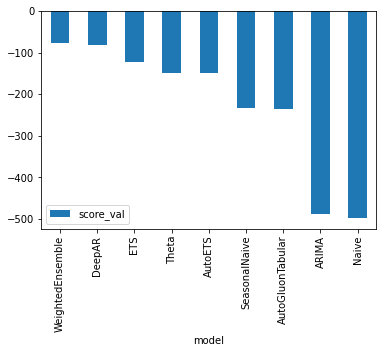

In [84]:
predictor = TimeSeriesPredictor.load('./AutogluonModels/ag-new-features-1h-sein-demand')
predictor.leaderboard().plot(kind="bar", x="model", y="score_val")
plt.show()

### Predictions

In [85]:
# leave num_days = 0 to generate forecasts on the entire test data
num_days = 0

In [86]:
num_instances = 0
if num_days != 0:
    num_instances = num_days * prediction_length
else:
    num_instances = len(test_data)

In [87]:
future_known_covariates = test_data[0:num_instances]

In [88]:
data = train_data
predictions = predictor.predict(data, known_covariates=future_known_covariates)
for i in range(0, num_instances - prediction_length, prediction_length):
    data = pd.concat([data, test_data[i: i + prediction_length]])
    new_predictions = predictor.predict(data, known_covariates=future_known_covariates)
    predictions = pd.concat([predictions, new_predictions])

Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Global seed set to 123
Model not specified in predict, will default to the model with the 

In [89]:
print(f"Number of predictions: {len(predictions)}")

Number of predictions: 5136


In [90]:
predictions.head()

mean          0.1          0.2  \
item_id timestamp                                                    
D1      2022-06-01 00:00:00  6223.240511  6120.959014  6152.768472   
        2022-06-01 01:00:00  5963.452451  5851.587519  5891.813111   
        2022-06-01 02:00:00  5778.940608  5668.988591  5709.939337   
        2022-06-01 03:00:00  5689.659342  5584.255703  5614.349058   
        2022-06-01 04:00:00  5685.790118  5575.399781  5610.844951   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
D1      2022-06-01 00:00:00  6184.331867  6202.345998  6217.595492   
        2022-06-01 01:00:00  5916.269886  5946.667453  5965.854795   
        2022-06-01 02:00:00  5733.962950  5760.780953  5777.077327   
        2022-06-01 03:00:00  5642.720277  5661.632824  5689.060709   
        2022-06-01 04:00:00  5634.881153  5664.271803  5691.421954   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
D1      2022-06-01 00:00:00  6245.418228  6267.202866  6293.127589   
        2022-06-01 01:00:00  5989.753562  6005.334234  6029.457025   
        2022-06-01 02:00:00  5798.552412  5822.658501  5853.019516   
        2022-06-01 03:00:00  5712.250313  5736.156024  5759.476950   
        2022-06-01 04:00:00  5711.442221  5732.422715  5758.626886   

                                     0.9  
item_id timestamp                         
D1      2022-06-01 00:00:00  6334.016637  
        2022-06-01 01:00:00  6070.673828  
        2022-06-01 02:00:00  5895.338914  
        2022-06-01 03:00:00  5799.185051  
        2022-06-01 04:00:00  5790.720493

### Evaluate predictions

In [91]:
rmse = mean_squared_error(
    test_data[0:num_instances]['sein_demand'], predictions['mean'],
    squared=False
)
print(f"RMSE: {rmse}")

RMSE: 111.48815320214159


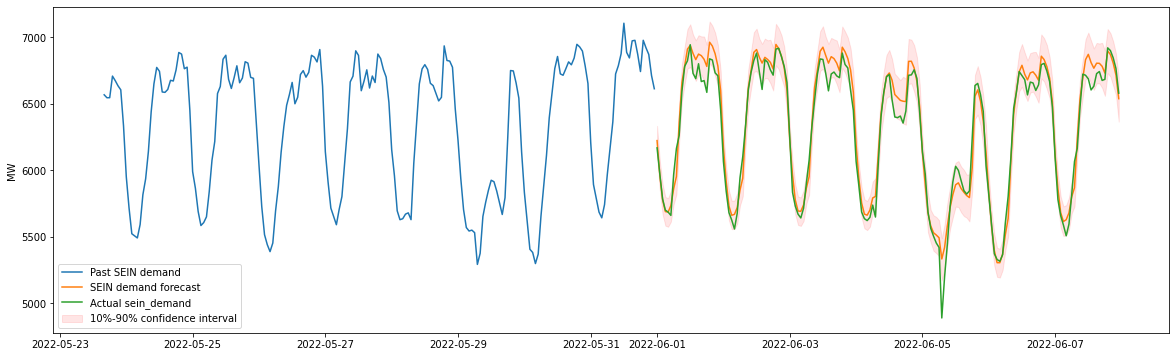

In [92]:
# demand forecast for first week of June 2022
plt.figure(figsize=(20, 6))

item_id = item_id
y_past = train_data.loc[item_id]["sein_demand"]
y_pred = predictions.loc[item_id][0:24*7]
y_test = test_data.loc[item_id]["sein_demand"][0:24*7]

plt.plot(y_past[-200:], label="Past SEIN demand")
plt.plot(y_pred["mean"], label="SEIN demand forecast")
plt.plot(y_test, label="Actual sein_demand")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red",
    alpha=0.1, label="10%-90% confidence interval"
)
plt.ylabel('MW')
plt.legend();

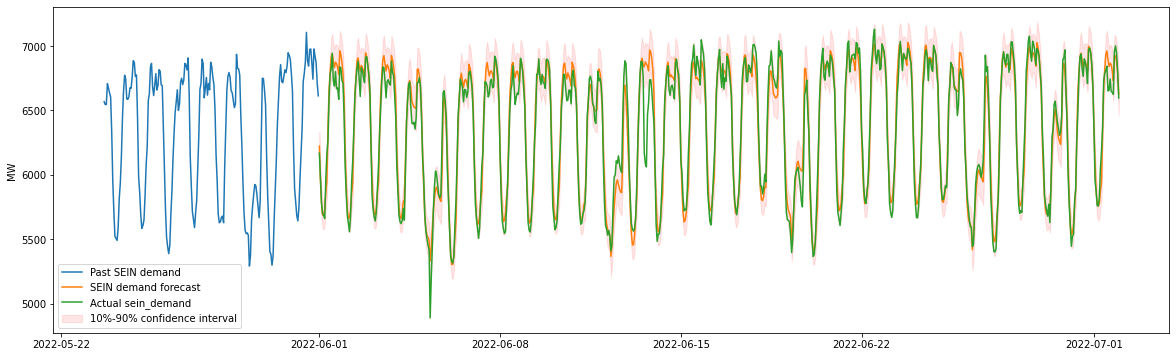

In [93]:
# demand forecast for June 2022
plt.figure(figsize=(20, 6))

item_id = item_id
y_past = train_data.loc[item_id]["sein_demand"]
y_pred = predictions.loc[item_id][0:24*31]
y_test = test_data.loc[item_id]["sein_demand"][0:24*31]

plt.plot(y_past[-200:], label="Past SEIN demand")
plt.plot(y_pred["mean"], label="SEIN demand forecast")
plt.plot(y_test, label="Actual sein_demand")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red",
    alpha=0.1, label="10%-90% confidence interval"
)
plt.ylabel('MW')
plt.legend();

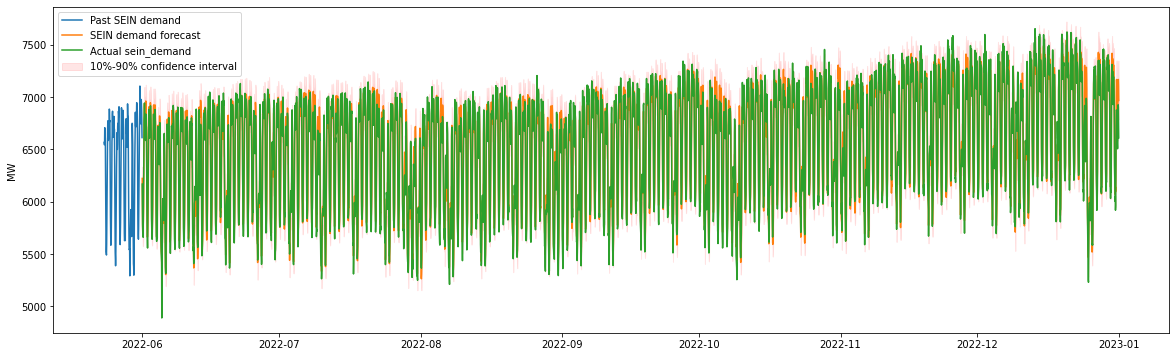

In [94]:
plt.figure(figsize=(20, 6))

item_id = item_id
y_past = train_data.loc[item_id]["sein_demand"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["sein_demand"][0:num_instances]

plt.plot(y_past[-200:], label="Past SEIN demand")
plt.plot(y_pred["mean"], label="SEIN demand forecast")
plt.plot(y_test, label="Actual sein_demand")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red",
    alpha=0.1, label="10%-90% confidence interval"
)
plt.ylabel('MW')
plt.legend();

#### Evaluate predictions on peak hours

In [95]:
df_predictions = predictions.reset_index()
df_predictions = df_predictions.rename(columns={
    'timestamp': 'datetime',
    'mean': 'predictions'})
df_predictions = df_predictions[['datetime', 'predictions']]
df_predictions = pd.merge(df_test, df_predictions, how='left', on='datetime')

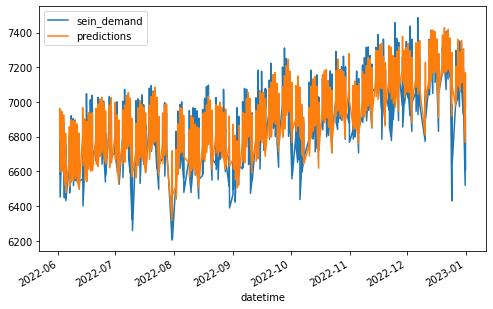

In [96]:
(df_predictions[df_predictions['on_peak']]
 .plot(x='datetime', y=['sein_demand', 'predictions'], figsize=(8, 5)))
plt.show()

In [97]:
idx = df_predictions[df_predictions['on_peak']].groupby(
    df_predictions['datetime'].dt.month)['predictions'].idxmax()
df_predictions.loc[idx, ['datetime', 'predictions']]

,datetime,predictions
547,2022-06-23 19:00:00,7027.191937
1219,2022-07-21 19:00:00,7084.729227
1892,2022-08-18 20:00:00,7034.499706
2899,2022-09-29 19:00:00,7246.004804
3668,2022-10-31 20:00:00,7279.075249
4340,2022-11-28 20:00:00,7378.525621
4868,2022-12-20 20:00:00,7428.872716


In [98]:
idx = df_predictions[df_predictions['on_peak']].groupby(
    df_predictions['datetime'].dt.month)['sein_demand'].idxmax()
df_predictions.loc[idx, ['datetime', 'sein_demand']]

,datetime,sein_demand
355,2022-06-15 19:00:00,7047.66300
1172,2022-07-19 20:00:00,7094.47800
1892,2022-08-18 20:00:00,7097.03160
2851,2022-09-27 19:00:00,7311.18590
3500,2022-10-24 20:00:00,7291.40000
4244,2022-11-24 20:00:00,7457.30800
4532,2022-12-06 20:00:00,7486.52074


## Evaluation of models

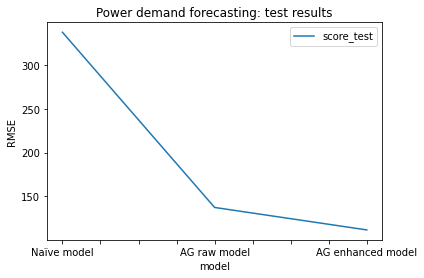

In [5]:
fig = pd.DataFrame(
    {
        "model": ["Naïve model", "AG raw model", "AG enhanced model"],
        "score_test": [337.7162, 137.2041, 111.4882]
    }
).plot(x="model", y="score_test", figsize=(6, 4)).get_figure()

plt.title('Power demand forecasting: test results')
plt.ylabel('RMSE')
fig.savefig('./images/model_test_scores.png')